In [8]:
%matplotlib inline

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# PID Controller
### Proportional-integral-derivative controller

## Introduction
A proportional–integral–derivative controller (also known as a three-term controller, though this is not always accurate – as we will see at the end of the Components section) is a feedback-based control loop mechanism commonly used to manage machines and processes that require continuous control and automatic adjustments. It is typically employed in industrial control systems where constant modulation is necessary without human intervention. Recently, it has also been used in everyday consumer technology. The PID controller automatically compares the target value (setpoint or $\text{SP}$) with the actual value of the system (process variable or $\text{PV}$). The difference between these two values is called the error value, denoted as $e(t)$.

The three correcting terms sum up to form the manipulated variable ($\text{MV}$). Let’s denote the controller output as $𝑢(𝑡)$ Thus, the final form of the PID controller algorithm can be expressed as:

$$ u(t) = MV(t) = K_p e(t) + K_i \int_{0}^{t} e(\tau) \text{d}\tau + K_\text{d} \frac{\text{d}e(t)}{\text{d}t} $$

It is important to note that:

$K_p$ (proportional gain), $K_i$ (integral gain), $K_d$ (derivative gain) are tuning parameters (more on that in the Tuning section)

$e(t) = \text{SP} - \text{PV}(t)$ is the error

$t$ is the time or instantaneous time (the present),

$\tau$ is the variable of integration (takes on values from time $0$ to the present $t$).

## Example use cases
Let’s start with three examples that we’ll explore to help us understand what the actual operation of this algorithm looks like in practice.
### Two-wheeled self-balancing robots
A common example is a two-wheeled robot that balances itself. When the robot tilts forward or backward, the PID controller adjusts the wheel speed to maintain balance. This is achieved by continuously measuring the tilt angle and adjusting the motor power to restore balance quickly and smoothly, preventing the robot from tipping over.
### Vehicle's cruise control system
Another common example is the cruise control system in a car. For instance, when a car is climbing a hill, its speed will drop if the engine’s power output remains constant. The PID controller automatically adjusts the engine power to bring the car back to the desired speed efficiently, with minimal delay and overshoot.
### Temperature control system
Another example is temperature control in an industrial oven. If the oven temperature drops below the setpoint due to sudden heat loss (for example, when the door is opened), the PID controller increases the heating element’s power output to return the temperature to the desired level efficiently, minimizing overshoot and ensuring stable operation.

## Components
The PID controller algorithm consists of three main parts. Each letter in PID corresponds to one of them.

It is important to note that there are situations in which one or two parts can be omitted. We will see examples of that further in this section.

We are going to dive into each of them separately by partialy implementing the **Temperature control system** example. (Let's get some water boiling)

However, before diving into the individual components, it would be helpful to have a way to visualize the results of each term. That’s why we need a plotting function.

In [260]:
def plot_single_term(time, process_values, setpoint, label, title, color='blue'):
    plt.figure(figsize=(10, 6))
    
    plt.plot(time, process_values, label=label, color=color)
    
    plt.axhline(setpoint, color='r', linestyle='--', label='Setpoint')
    plt.xlabel('Time (s)')
    plt.ylabel('Process Variable')
    
    plt.title(title)
    plt.legend()
    
    plt.grid()
    
    plt.show()

We will also need values for the functions to work properly

In [261]:
# Desired temperature inside the oven
setpoint = 100

# Starting temperature inside the oven
initial_process_variable = 20

# Small time interval for precise calculations
dt = 0.1

# 10-second time interval while the oven is closed
time = np.arange(0, 10, dt)

# Heat loss coefficient while oven is closed
heat_loss_coeff = 0.1

Almost forgot, we need our PID controller simulation function.

In [262]:
# Values are set to 0 by default so if we want to test the controller with omitted value, we could
def simulate_pid_control(Kp = 0, Ki = 0, Kd = 0):
    process_variable = initial_process_variable
    previous_error = 0
    integral = 0
    process_values = []

    for t in time:
        error = setpoint - process_variable  # current error e(t)

        # Proportional term (applying the proportional gain to the current error)
        P_out = Kp * error  # proportional output

        # Integral term (accumulating the error over time and applying integral gain)
        integral += error * dt  # update the accumulated integral
        I_out = Ki * integral   # integral output

        # Derivative term (calculating rate of change of error and applying derivative gain)
        derivative = (error - previous_error) / dt  # how fast error changes over time
        D_out = Kd * derivative  # derivative output

        # PID output (sum of active terms)
        output = P_out + I_out + D_out

        # Update the process variable based on PID output and heat loss
        process_variable += output * dt - heat_loss_coeff * (process_variable - initial_process_variable) * dt
        process_values.append(process_variable)

        # Prepare for next iteration
        previous_error = error

    # Returns the time array and corresponding process variable values for plotting
    return time, process_values

### P - Proportional
The proportional term generates an output that directly relates to the current error value. This response is controlled by multiplying the error by a proportional gain constant $K_p$.

The proportional term is given by

$$ P_{out} = K_p e(t) $$

When $K_p$ is high, even a small change in error causes a large output adjustment, which can make the system unstable if set too high. On the other hand, a low $K_p$ leads to a weak output response even for significant errors, making the controller less sensitive and slower to react. If $K_p$ is too low, the controller might not correct disturbances effectively.

In [263]:
time_p, pv_p = simulate_pid_control(Kp=1.0)

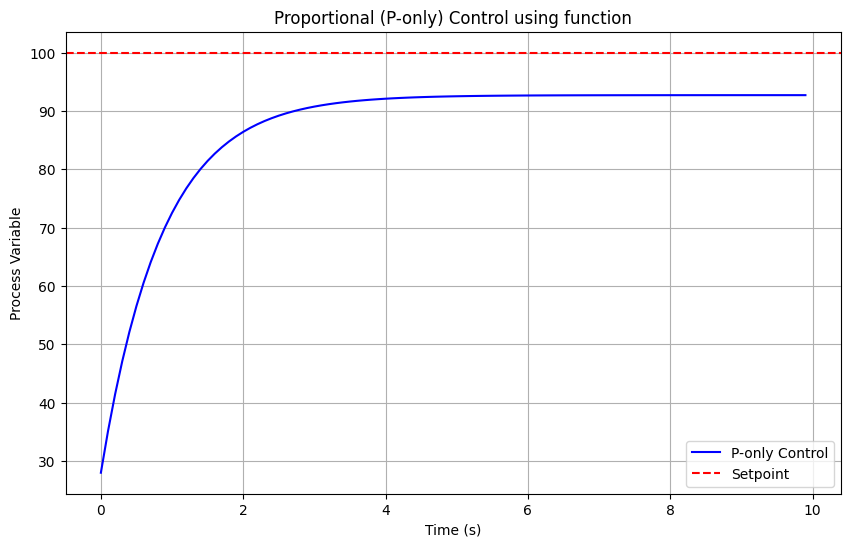

In [264]:
plot_single_term(time_p, pv_p, setpoint, label='P-only Control', title='Proportional (P-only) Control using function', color='blue')

As we can see from the diagram for the Proportional (P) component, it takes about 2.5 seconds to get close to the desired temperature. However, this component alone cannot reach the target temperature of 100 degrees and stays a bit above 90 degrees instead.

### I - Integral
The integral term accounts for both how large the error is and how long it lasts. It sums up the error over time, capturing the total accumulated deviation that should have been corrected before. This accumulated error is then multiplied by the integral gain ($K_i$) and added to the controller’s output.

The integral term is given by

$$ I_{out} = K_i \int_{0}^{t} e(\tau) \text{d}\tau $$

The integral action helps the process reach the target value faster and removes the steady-state error that a proportional controller alone cannot fix. However, since it reacts to past accumulated errors, it may cause the process to overshoot the desired setpoint.

In [265]:
time_i, pv_i = simulate_pid_control(Ki=0.1)

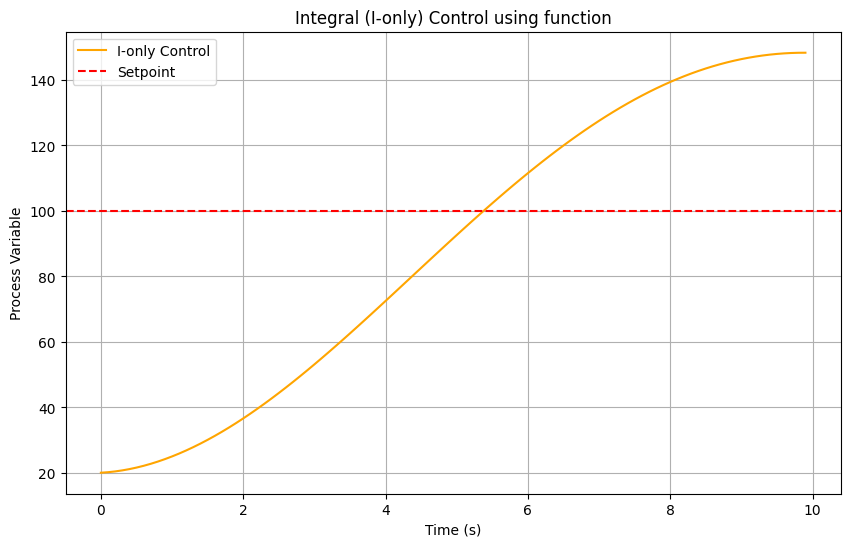

In [266]:
plot_single_term(time_i, pv_i, setpoint, label='I-only Control', title='Integral (I-only) Control using function', color='orange')

As we can see from the diagram for the Integral (I) component, it takes a little over 5.5 seconds to reach the desired temperature. However, this component alone cannot maintain the desired temperature of 100 degrees. Instead, it immediately overshoots after reaching it, eventually plateauing at around 150 degrees.

### D - Derivative
The derivative term is found by measuring how fast the error changes over time and then multiplying this rate by the derivative gain, $K_d$. This gain determines the influence of the derivative term on the overall control output.

$$ D_{out} = K_\text{d} \frac{\text{d}e(t)}{\text{d}t} $$

Derivative control helps predict the system’s future behavior, which improves how quickly the system stabilizes and increases its stability. Since an ideal derivative can’t be implemented directly, practical PID controllers apply a low-pass filter to the derivative term to reduce noise and limit high-frequency effects.

Despite these benefits, derivative action is seldom used in practice - estimated to be included in only about 25% of controllers—because it can have unpredictable effects on system stability in real-world conditions.

In [267]:
time_d, pv_d = simulate_pid_control(Kd=0.5)

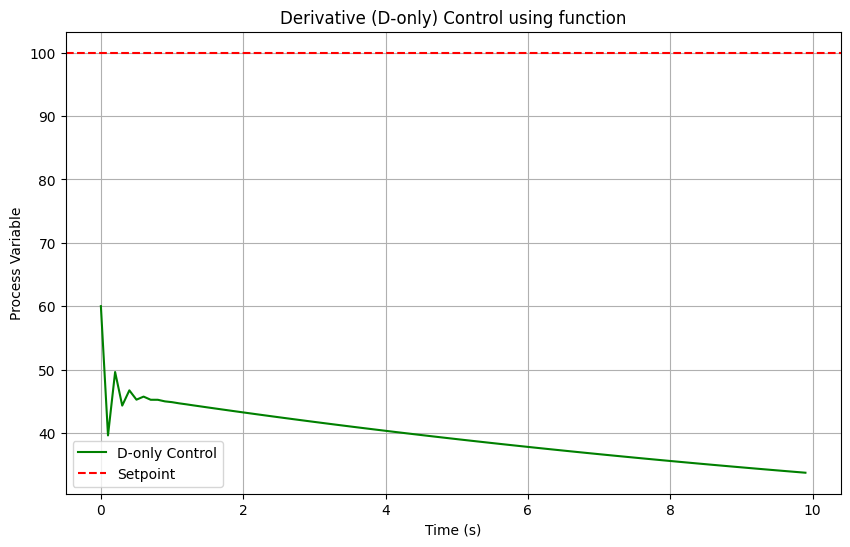

In [268]:
plot_single_term(time_d, pv_d, setpoint, label='D-only Control', title='Derivative (D-only) Control using function', color='green')

As we can see from the diagram for the Derivative (D) component, the (D) never reaches the desired temperature. On the contrary, initially (within the first half-second), we see noise, after which the temperature starts to decrease. This is the exact opposite of what we’re looking for. The conclusion is that this component alone cannot perform the task.

### How do they work together
The PID controller automatically applies corrections to bring the $\text{PV}$ to the same value as the $\text{SP}$. The Proportional (P) component responds to the current error value by producing an output that is directly proportional to the magnitude of the error. At the same time, the Integral (I) component considers the cumulative sum of past errors to eliminate residual steady-state errors that persist over time, thus removing any remaining discrepancies. Finally, the Derivative (D) component predicts future errors by assessing the rate of change of the error, which helps reduce overshoot and enhance system stability, especially during sudden changes.

After we combine the three separate parts we get the final formula

$$ K_p e(t) + K_i \int_{0}^{t} e(\tau) \text{d}\tau + K_\text{d} \frac{\text{d}e(t)}{\text{d}t} $$

In [270]:
time_pdi, pv_pdi = simulate_pid_control(Kp=1.0, Ki=0.1, Kd=0.5)

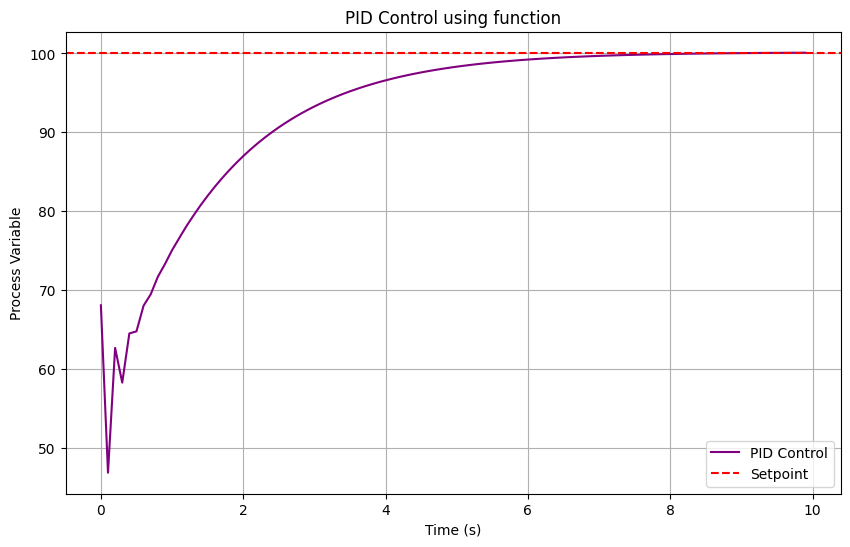

In [271]:
plot_single_term(time_pdi, pv_pdi, setpoint, label='PID Control', title='PID Control using function', color='purple')

When we use all three components of the PID, we again see noise during the first half-second, after which the controller manages to reach the desired temperature roughly at the eighth second. This means that the combination of PID components succeeds in reaching the desired temperature.

In [273]:
time_pdi, pv_pdi = simulate_pid_control(Kp=1.0, Ki=0.1, Kd=0.0)

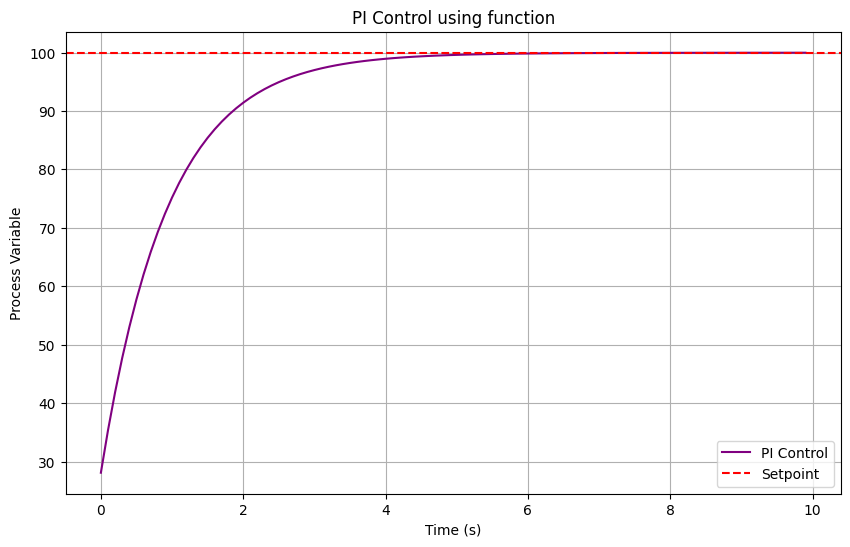

In [274]:
plot_single_term(time_pdi, pv_pdi, setpoint, label='PI Control', title='PI Control using function', color='purple')

However, when we reduce the (D) component, we see that the noise decreases and the value reaches the desired level more quickly (around the fifth second). In such cases, it’s clear that the (D) component is not essential—in fact, sometimes it is more optimal without it.

### Selective use of control terms
Although the PID controller algorithm consists of three parts, there are situations in which one or two of them are sufficient to provide proper control. This can be achieved by setting the unused values to zero. In such cases, the algorithm is referred to as a PI, PD, P, or I controller. The integral part is often necessary for the system to reach the desired output. For example, the PID algorithm is frequently used in its PI form in cases where differentiation would be sensitive to measurement noise.

As mentioned in the Derivative subsection, the letter D is often omitted from the algorithm. Let's see an example for a PI controller

Good example for PI usage is a **Lighting Control in a Room with a Lamp**

In a lighting control system for a room, the goal is to maintain constant brightness, compensating for changes in natural light. These changes are usually smooth and gradual — for example, during sunset. In this case, PI control (proportional and integral) is sufficient to ensure stable regulation without a steady-state error. Adding a derivative term in this situation is rarely necessary and can even introduce unnecessary noise into the system, since there are no abrupt changes that would require predicting future behavior.

### What happens if there is a missing component?
We already saw an example where the derivative part can be omitted. However, it is not always the best idea to skip the Derivative term. What would happen if it is required and not present? What problems could occur?

Good example for PI that needs its Derivative term is a **Position Control of a Robotic Manipulator Arm**

In control systems for robotic manipulators performing precise movements, the derivative (D) component is extremely important. The arm's position must be controlled with high accuracy, and the movements are often fast and abrupt. Without the D component, the controller would only react to the current error and the accumulated integral error, which can lead to oscillations or excessive delay in reaching the target position. The derivative term anticipates the future behavior of the error, reducing oscillations and improving the stability and accuracy of the motion.

## Tuning
### Why is it important?
PID tuning is the process of determining the optimal values for the three main parameters of a PID controller: the proportional (P), integral (I), and derivative (D) gains. The goal is to make the system respond quickly, stably, and accurately to changes, without oscillations or delays.

### Methods for tuning a PID controller
There are various methods for tuning PID controllers, and there is no universal choice. Different methods are more suitable for different tasks.

**Ziegler–Nichols method** is an empirical method in which the ultimate gain $(K_u)$ and the oscillation period $(T_u)$ are determined to calculate the optimal PID parameters.

**Trial-and-error method** is manual adjustment of the parameters by observing the system’s response and making corrections until the desired behavior is achieved.
This method is the fastest and easiest to use, but it offers almost no guarantee that it will work. Additional testing is usually required.

**Modern PID controllers** often have built-in features or work with specialized software that automatically selects the optimal settings.
Instead of manual calculations, the system analyzes the process behavior (for example, how quickly water temperature responds to heat input) and automatically calculates appropriate values for (P), (I), and (D).

## Advantages and disadvantages of PID
### Advantages
* Simplicity and versatility

* PID controllers are easy to understand and implement, even without a complex mathematical model of the system.

* They work well in a wide range of industrial applications.

* Low computational complexity

* They operate with simple calculations – no need for matrices, neural networks, or simulations.

* This makes them suitable for embedded systems with limited resources.

* Good stability and fast response

* When properly tuned, the PID controller provides a fast response with minimal deviation and no prolonged oscillations.

* Flexibility

* Each of the three components (P, I, D) can be enabled or disabled depending on the system's needs.

### Disadvantages
* Dependence on tuning (sometimes tuning being crucial).

* Tuning sometimes relies on trial and error, without any mathematical justification.

* There are no “universal” PID values. Incorrect tuning can lead to oscillations, delays, or instability.

* In real-world situations where the system’s behavior changes under different conditions (nonlinearity), PID controllers can become ineffective.

* Sensitivity to noise.

* The derivative component (D) can amplify measurement noise, potentially leading to instability, especially in real-world environments with sensor noise.

## Alternatives to the PID
**Model Predictive Control (MPC)**

* Uses a mathematical model to predict the future behavior of the system.

* Allows for optimal control with constraints (e.g., temperature should not exceed a certain limit).

* Suitable for complex and multivariable systems but requires high computational power.

**Neural networks and machine learning**

* Used for adaptive control in systems with nonlinear dynamics.

* They can “learn” how to control the system even without prior knowledge.

* However, they require large amounts of data and significant computational power.

## In conclusion
The PID controller is a flexible algorithm with three components that are essential for maintaining a desired value. However, not every task requires all three components to be active - sometimes it’s more optimal to leave one out. Unfortunately, the controller isn’t fully autonomous. It requires tuning to function properly. Despite this major drawback, it remains the most widely used algorithm for such tasks, both in industry and in everyday applications.

## Dictionary
**Set Point:** Set Point is a value that is usually set by the user. In the example of cruise control, it is the desired speed that the vehicle should maintain.

**Process Value:** Process Value is the value that is processed by the PID controller. In the cruise control example, this is the current (actual) speed of the vehicle.

**Output:** The output of the PID controller is calculated by summing the proportional, integral, and derivative terms. Their effect on the output depends on their respective gain coefficients. In a cruise control system, for example, the output of the PID controller is the control signal to the throttle valve.

**Error:** Error is the value used by the PID controller to determine how to adjust the output so that the process value approaches the set point.

**Gain:** Gain is used as a multiplication factor for the three PID terms – Proportional, Integral, and Derivative. By adjusting it, the user can control the influence of the PID controller on the entire system.

## Sources
[Proportional–integral–derivative controller - Wikipedia](https://en.wikipedia.org/wiki/Proportional%E2%80%93integral%E2%80%93derivative_controller)

[PID explained](https://pidexplained.com/pid-controller-explained/)

[How to tune PID](https://pidexplained.com/how-to-tune-a-pid-controller/)

[Basic implementation (only used for reference)](https://medium.com/@aleksej.gudkov/python-pid-controller-example-a-complete-guide-5f35589eec86)